In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/127851585.gadi-pbs'

In [173]:
def _distq(lon1, lat1, lon2, lat2):
    """
    Compute the geodesic distance between lat/lon points. This code is
    taken from the dist.f routine and the Matlab version distg.m passed
    around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    distance : array or scalar of distance in meters
    angle: array or scalar of angle in radians

    """
    lon1 = np.asanyarray(np.radians(lon1))
    lat1 = np.asanyarray(np.radians(lat1))
    lon2 = np.asanyarray(np.radians(lon2))
    lat2 = np.asanyarray(np.radians(lat2))

    # # If one of the points is a singleton and the other is an
    # array, make them the same size
    if lon1.size == 1 and lon2.size > 1:
        lon1 = lon1.repeat(lon2.size)
        lat1 = lat1.repeat(lat2.size)
    if lon2.size == 1 and lon1.size > 1:
        lon2 = lon2.repeat(lon1.size)
        lat2 = lat2.repeat(lat1.size)

    # Set the WGS84 parameters
    A = 6378137.
    E = 0.081819191
    B = np.sqrt(A * A - (A * E)**2)
    EPS = E * E / (1.0 - E * E)

    # Move any latitudes off of the equator
    lat1[lat1 == 0] = np.finfo(float).eps
    lat2[lat2 == 0] = -np.finfo(float).eps

    # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
    xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
    xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

    TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
        (xnu2 * np.cos(lat2))
    PSI2 = np.arctan(TPSI2)

    DPHI2 = lat2 - PSI2
    DLAM = (lon2 - lon1) + np.finfo(float).eps
    CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
    A12 = np.arctan(CTA12)
    CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                            np.cos(PSI2) * np.tan(lat1))
    A21P = np.arctan(CTA21P)

    # C    GET THE QUADRANT RIGHT
    DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
        (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
        (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
    A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
        (A12 >= np.pi).astype(int) * 2 * np.pi
    A12 = A12 + np.pi * np.sign(-A12) * \
        (np.sign(A12).astype(int) != np.sign(DLAM2))
    A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
        (A21P >= np.pi).astype(int) * 2 * np.pi
    A21P = A21P + np.pi * np.sign(-A21P) * \
        (np.sign(A21P).astype(int) != np.sign(-DLAM2))

    SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

    dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                    np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
    dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                    np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
    dd2 = np.sum((dd2 - dd1)**2, axis=0)
    bigbrnch = (dd2 > 2).astype(int)

    SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
        (np.pi - np.arcsin(SSIG)) * bigbrnch

    SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
    SIGC = np.arcsin(SSIGC)
    A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

    # C   COMPUTE RANGE
    G2 = EPS * (np.sin(lat1))**2
    G = np.sqrt(G2)
    H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
    H = np.sqrt(H2)
    SIG2 = SIG * SIG
    TERM1 = -H2 * (1.0 - H2) / 6.0
    TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
    TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
    TERM4 = -G * H / 48.0
    rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                    SIG2 * SIG * TERM4))

    return rng, A12


def earth_angle(lon1, lat1, lon2, lat2):
    """
    Compute the angle between lat/lon points. NOTE: The bearing angle
    is computed, but then converted to geometric (counter-clockwise)
    angle to be returned.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    angle : array or scalar of bearing in radians

    """
    _, angle = _distq(lon1, lat1, lon2, lat2)
    # return (np.pi / 2.0 - angle)
    return (angle)



In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))


ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


In [6]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['u_rho_doy']=ds_CTRL.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['v_rho_doy']=ds_CTRL.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

# ds_FIT0['day']=dayofyear_da
# ds_FIT0['salt_doy']=ds_FIT0.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_FIT0['my_doy']=ds_FIT0.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

# ds_AIS0['day']=dayofyear_da
# ds_AIS0['salt_doy']=ds_AIS0.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_AIS0['my_doy']=ds_AIS0.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

# ds_AIS2['day']=dayofyear_da
# ds_AIS2['salt_doy']=ds_AIS2.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_AIS2['my_doy']=ds_AIS2.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


# ds_AIS05['day']=dayofyear_da
# ds_AIS05['salt_doy']=ds_AIS05.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_AIS05['my_doy']=ds_AIS05.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


/jobfs/127851585.gadi-pbs/ipykernel_3964365/4242197625.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p = cs.collections[0].get_paths()[0]


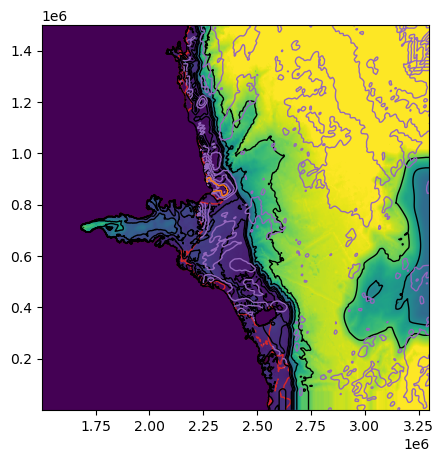

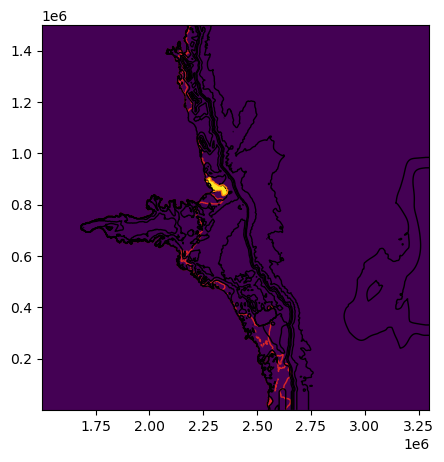

In [7]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley
# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



In [8]:
# # now load lima

# import rioxarray

# lima_full = rioxarray.open_rasterio('../data/raw/lima/00000-20080319-092059124.tif')

# lima = lima_full.where((lima_full.x>1.68e6)&(lima_full.x<2.5e6)&(lima_full.y>.4e6)&(lima_full.y<1e6),drop=True)


### finished preliminary loading data

In [9]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds.ocean_time.isel(ocean_time=winter_period)[0].values,' to ',ds.ocean_time.isel(ocean_time=winter_period)[-1].values)
print(ds.ocean_time.isel(ocean_time=summer_period)[0].values,' to ',ds.ocean_time.isel(ocean_time=summer_period)[-1].values)

2055-09-03T12:00:00.000000000  to  2055-11-02T12:00:00.000000000
2055-03-02T12:00:00.000000000  to  2055-05-01T12:00:00.000000000


In [10]:
ds_CTRL

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(32, 750, 900), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 750, 900), meta=np.ndarray>
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/109)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [11]:
%%time

# dump the big fields
ds_CTRL = ds_CTRL.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds_CTRL.nbytes/1e9,'G')
ds_CTRL.load()

86.260773352 G
CPU times: user 8min 31s, sys: 10min 58s, total: 19min 29s
Wall time: 10min 56s


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 1.502e+06 1.504e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -3.873
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/98)
    ntimes             int32 131400
    ndtfast            int32 40
    dt                 float64 240.0
    dtfast             float64 6.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 1800
    ...                 ...
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 nan ... 0...
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 34.33
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 1.214
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 0....
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [14]:
%%time

# calculate potential density

import seawater as sw

sigma_0 = np.ones((ds_CTRL.s_rho.size,ds_CTRL.dayofyear.size,ds_CTRL.eta_rho.size,ds_CTRL.xi_rho.size))*np.NaN
for nn in range(len(ds_CTRL.s_rho)):
    print(nn)
    sigma_0[nn,:,:,:] = sw.pden(ds_CTRL.salt_doy.isel(s_rho=nn).values,sw.temp(ds_CTRL.salt_doy.isel(s_rho=nn).values,ds_CTRL.temp_doy.isel(s_rho=nn).values, \
                                                                             ds_CTRL.z_rho0.isel(s_rho=nn).values),ds_CTRL.z_rho0.isel(s_rho=nn).values,0)-1000
sigma_0 = np.transpose(sigma_0,(1,0,2,3))
ds_CTRL['sigma_0_doy']=(('dayofyear','s_rho','eta_rho','xi_rho'),sigma_0)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
CPU times: user 12min 21s, sys: 6min 42s, total: 19min 3s
Wall time: 19min 13s


Text(0.5, 1.0, 'Bottom potential density anom (kg/m$^3$)')

<Figure size 640x480 with 0 Axes>

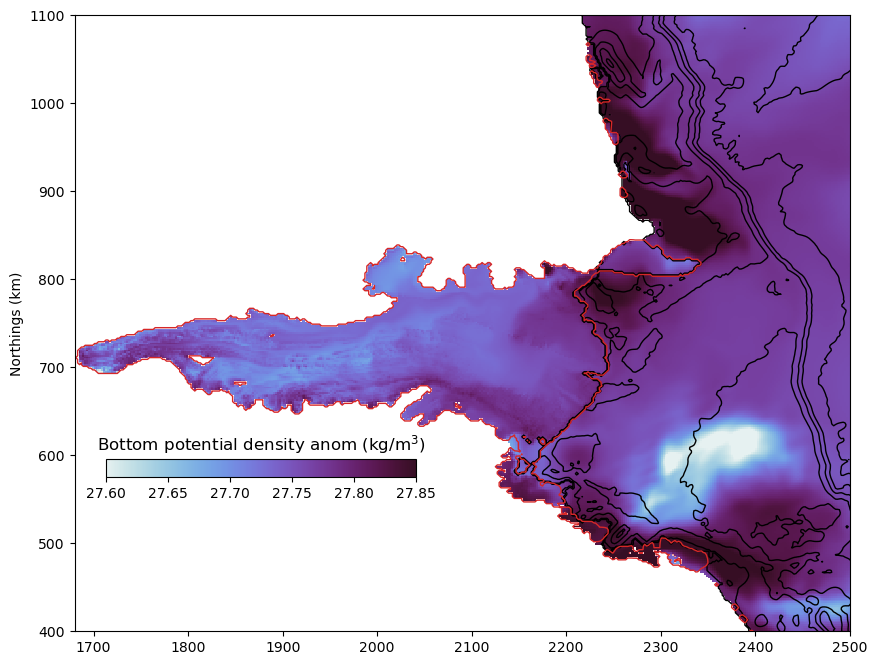

In [15]:
# test plot bottom-layer density

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None
winter_period
ax=fig.add_subplot(gs[0,0])

im2 = ds_CTRL.sigma_0_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.dense',\
                                                                                                  vmin=27.6,vmax=27.85,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.1e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Bottom potential density anom (kg/m$^3$)')


# annotations


27.6
27.62
27.64
27.66
27.68
27.7
27.72
27.74
27.759999999999998
27.779999999999998
27.799999999999997
27.819999999999997
27.839999999999996
27.859999999999996
27.879999999999995
27.899999999999995
27.919999999999995
27.939999999999994
27.959999999999994
27.979999999999993
27.999999999999993
28.019999999999992
28.039999999999992
28.05999999999999
28.07999999999999
28.09999999999999
28.11999999999999
28.13999999999999
28.15999999999999
28.17999999999999


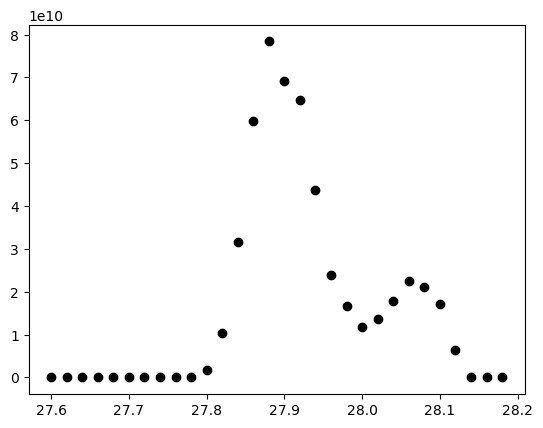

In [16]:
depth_res = 0.02
plt.figure()
for depth_class in np.arange(27.6,28.2,depth_res):
    print(depth_class)
    val= (((ds_CTRL.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)>depth_class) & (ds_CTRL.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)<=depth_class+depth_res))*ds_CTRL.dz*ds_CTRL.dA).sum(('s_rho','eta_rho','xi_rho')) 
    plt.plot(depth_class,val,'k-o')
    # print(
# (ds_CTRL.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)*ds_CTRL.dz*ds_CTRL.dA).sum(('s_rho','eta_rho','xi_rho'))

In [17]:
(((ds_CTRL.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)>27.8) & (ds_CTRL.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)<27.82))*ds_CTRL.dz*ds_CTRL.dA).sum(('s_rho','eta_rho','xi_rho'))

<xarray.DataArray ()>
array(1.72738041e+09)
Coordinates:
    dayofyear  int64 276

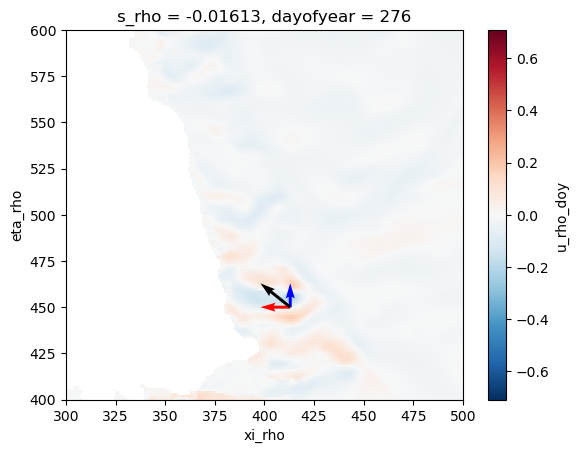

(66.0, 71.0, -68.0, -66.0)

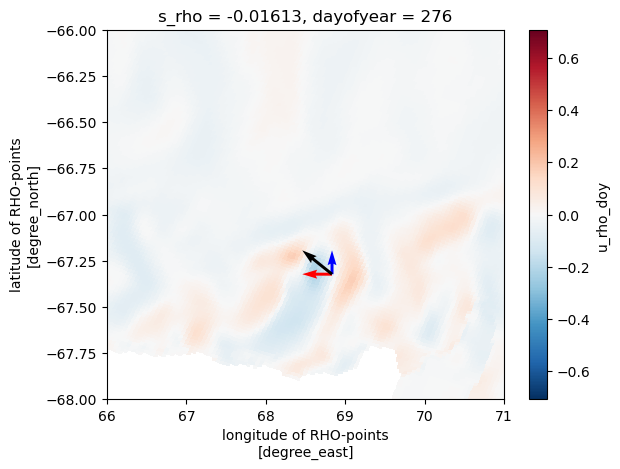

In [40]:
ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55).plot()
plt.quiver(413,450,ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),0,scale=.5,color='r')
plt.quiver(413,450,0,ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),scale=.5,color='b')

plt.quiver(413,450,ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),scale=.5)
plt.axis((300,500,400,600))
plt.show()
ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55).plot(x='lon_rho',y='lat_rho')
plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),0,scale=.5,color='r')
plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),0,ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),scale=.5,color='b')

plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450),scale=.5)
plt.axis((66,71,-68,-66))

(66.0, 71.0, -68.0, -66.0)

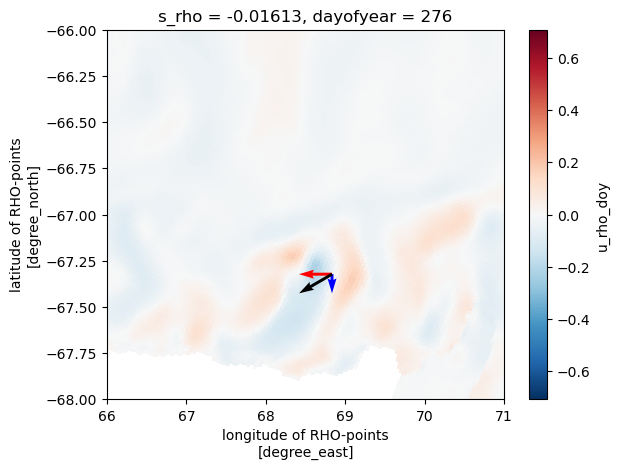

In [44]:


xrot = ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450) * np.cos(ds_CTRL.angle.isel(xi_rho=413,eta_rho=450)) - ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450) * np.sin(ds_CTRL.angle.isel(xi_rho=413,eta_rho=450))
yrot = ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450) * np.sin(ds_CTRL.angle.isel(xi_rho=413,eta_rho=450)) + ds_CTRL.v_rho_doy.isel(s_rho=-1,dayofyear=55,xi_rho=413,eta_rho=450) * np.cos(ds_CTRL.angle.isel(xi_rho=413,eta_rho=450))


ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55).plot(x='lon_rho',y='lat_rho')
plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),xrot,0,scale=.5,color='r')
plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),0,yrot,scale=.5,color='b')

plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),xrot,yrot,scale=.5)
plt.axis((66,71,-68,-66))


Text(0.5, 1.0, 'Bottom potential density anom (kg/m$^3$)')

<Figure size 640x480 with 0 Axes>

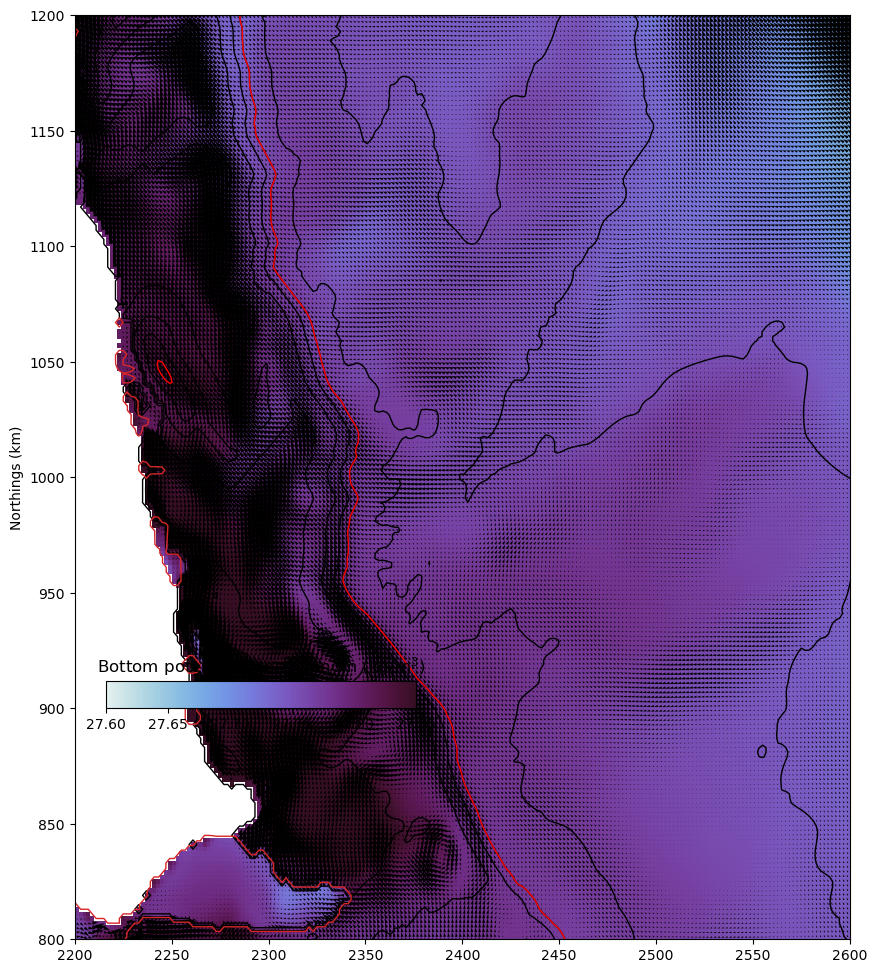

In [76]:
# test plot bottom-layer density

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,12])
ax = None
winter_period
ax=fig.add_subplot(gs[0,0])

im2 = ds_CTRL.sigma_0_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.dense',\
                                                                                                  vmin=27.6,vmax=27.85,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[1000],colors='r',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
qui = plt.quiver(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.u_rho_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear'),ds_CTRL.v_rho_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear'),scale=8,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.8e6,1.2e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Bottom potential density anom (kg/m$^3$)')


# annotations


/jobfs/127851585.gadi-pbs/ipykernel_3964365/3810499765.py:5: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p = cs.collections[0].get_paths()[0]


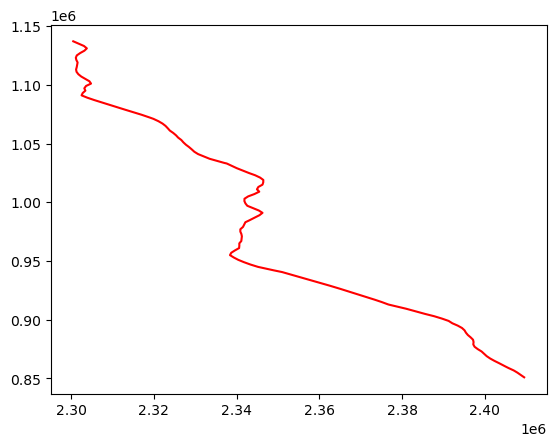

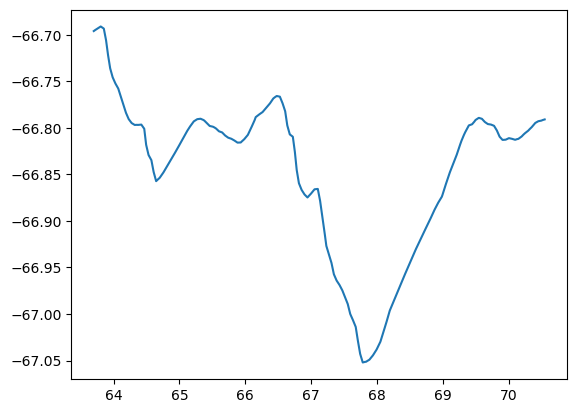

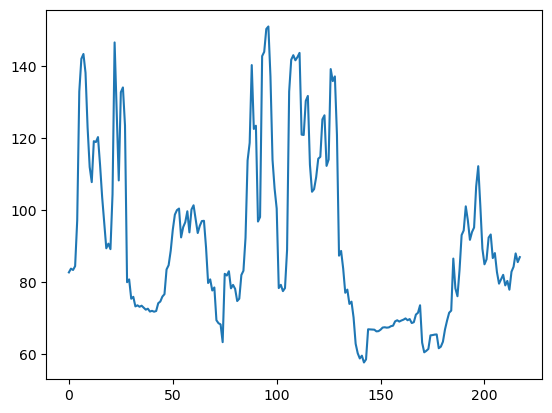

In [712]:
# make a contour with angle

level = 1000
cs = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[level],colors='r',linestyles='-',linewidths=1)
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

# plt.plot(x,y)

cont_where = ((x>2.3e6) & (x<2.45e6)) & ((y>.85e6) & (y<1.2e6))

plt.plot(x[cont_where],y[cont_where],'r')


# now convert those contour points to lat/lon
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


cont_lat,cont_lon = ps_to_ll.transform(x[cont_where],y[cont_where])
cont_x = x[cont_where]
cont_y = y[cont_where]

# cont_lat=np.array((-65,-66,-66,-67,-68))
# cont_lon=np.array((66,67,68,69,69))
plt.show()
plt.plot(cont_lon,cont_lat)

# Calculate the angle between the points
test = earth_angle(cont_lon[:-1],cont_lat[:-1], cont_lon[1:], cont_lat[1:])
plt.show()
plt.plot(np.rad2deg(test))
# now calculate the azimuth from point to point


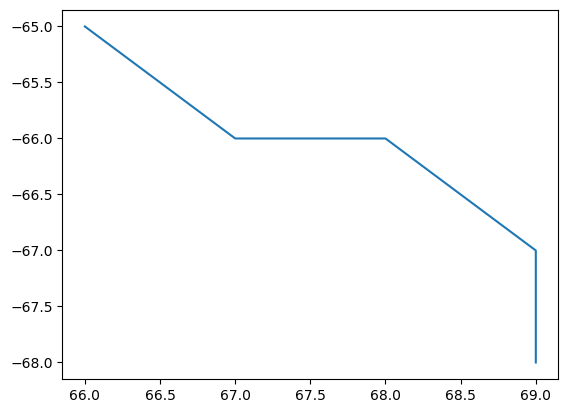

[157.90728916  90.45677465 158.69709158 180.        ]
[120724.1476595   45404.24846832 120067.17996634 111528.80424335]


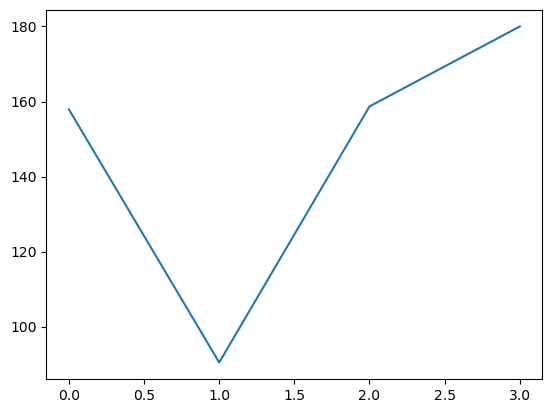

In [713]:

cont_lat=np.array((-65,-66,-66,-67,-68))
cont_lon=np.array((66,67,68,69,69))

from pyproj import Geod
geodesic = Geod(ellps='WGS84')
fwd_azimuth,back_azimuth,distance = geodesic.inv(cont_lon[:-1], cont_lat[:-1], cont_lon[1:], cont_lat[1:])

plt.show()
plt.plot(cont_lon,cont_lat)
plt.show()
plt.plot(fwd_azimuth)
print(fwd_azimuth)
print(distance)



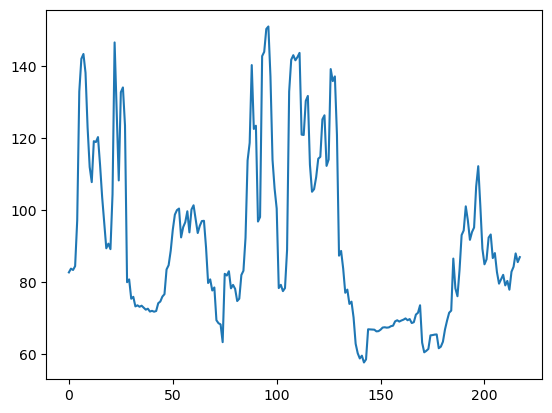

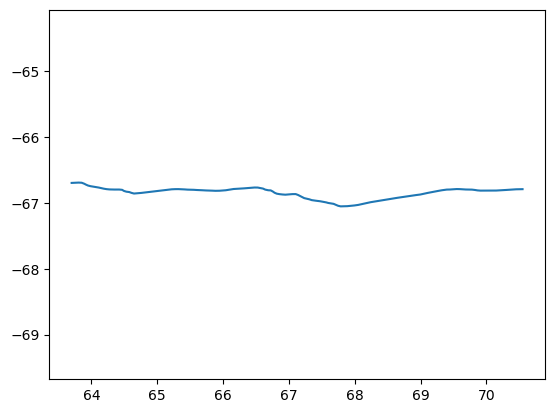

(2295030.61867796, 2414974.934621123, 836700.0008571128, 1151300.0009730288)

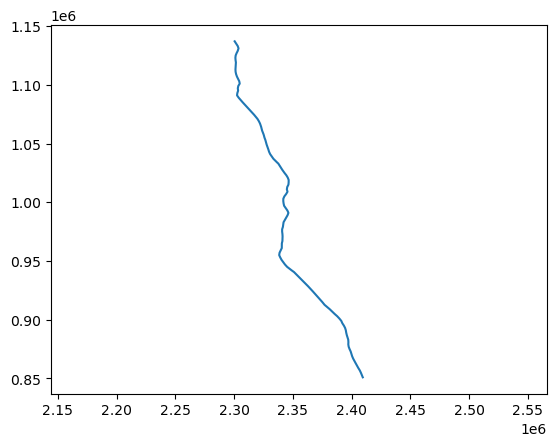

In [714]:
# ok now let's actually calculate the rad angle along the contour

# now convert those contour points to lat/lon
from pyproj import Transformer
from pyproj import CRS
from pyproj import Geod
geodesic = Geod(ellps='WGS84')

ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


cont_lat,cont_lon = ps_to_ll.transform(x[cont_where],y[cont_where])


# Calculate the angle between the points
fwd_azimuth,back_azimuth,distance = geodesic.inv(cont_lon[:-1], cont_lat[:-1], cont_lon[1:], cont_lat[1:])

az_rad = np.deg2rad(fwd_azimuth)
plt.show()
plt.plot(fwd_azimuth)

plt.show()
plt.plot(cont_lon,cont_lat)
plt.axis('equal')

plt.show()
plt.plot(cont_x,cont_y)
plt.axis('equal')

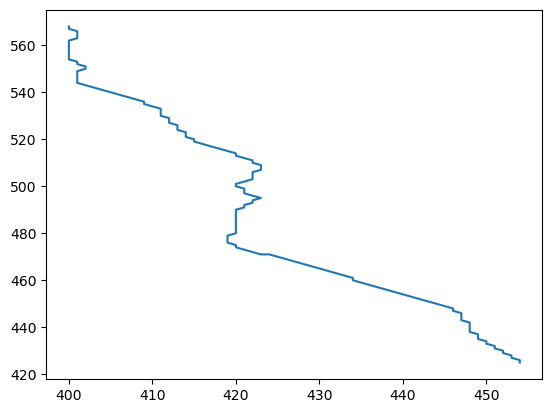

In [715]:
## thank eff for chatgpt

# Sample longitude and latitude grids
lon_grid = ds_CTRL.y_rho.values
lat_grid = ds_CTRL.x_rho.values

# Coordinates array to find closest indices for
coordinates = np.column_stack((cont_y, cont_x))

# Initialize arrays to store closest indices
closest_indices = []

for coord in coordinates:
    lon_point, lat_point = coord
    # Calculate distances from each point in lon_grid and lat_grid
    distances = np.sqrt((lon_grid - lon_point)**2 + (lat_grid - lat_point)**2)
    # Find the indices of the minimum distance
    closest_idx = np.unravel_index(np.argmin(distances), distances.shape)
    closest_indices.append(closest_idx)

# Convert result to a numpy array
closest_indices = np.array(closest_indices)

cont_xi = closest_indices[:,1] # axes are reversed to what you'd expect.
cont_eta= closest_indices[:,0]


plt.plot(cont_xi,cont_eta)

(2295030.61867796, 2414974.934621123, 836700.0008570284, 1151300.0009731022)

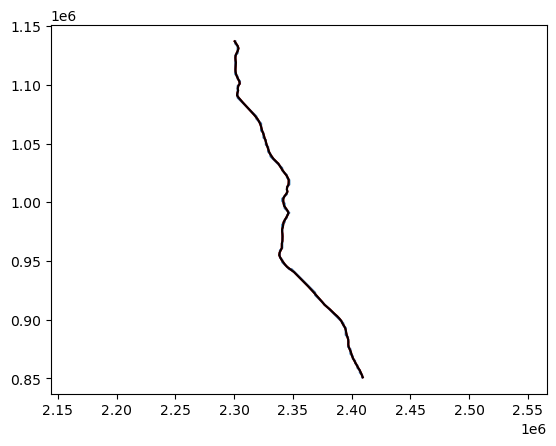

In [716]:

cont_xi_x = np.empty_like(cont_x)
cont_eta_y= np.empty_like(cont_x)

for ii in range(len(cont_xi)):
    cont_xi_x[ii] = ds_CTRL.x_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    cont_eta_y[ii] = ds_CTRL.y_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    
plt.plot(cont_xi_x,cont_eta_y)
plt.plot(cont_x,cont_y,'r')
plt.plot(x[cont_where],y[cont_where],'k')

plt.axis('equal')

In [717]:
# extract velocities at these points
u_rho_cont = np.empty((len(ds_CTRL.dayofyear),len(ds_CTRL.s_rho),len(cont_xi)))*np.NaN
v_rho_cont = np.empty((len(ds_CTRL.dayofyear),len(ds_CTRL.s_rho),len(cont_xi)))*np.NaN
h_cont = np.empty((len(cont_xi)))*np.NaN


for ii in range(len(cont_xi)):
    u_rho_cont[:,:,ii] = ds_CTRL.u_rho_doy.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    v_rho_cont[:,:,ii] = ds_CTRL.v_rho_doy.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    h_cont[ii] = ds_CTRL.h.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values

    
# now we have the u_rho and v_rho velocities along the contour (noting that these are velocities relative to the model grid directions
#  so on the PS grid. I could rotate these to the lat/lon grid, or I could rotate them to be along/across the 
#  shelf break contour

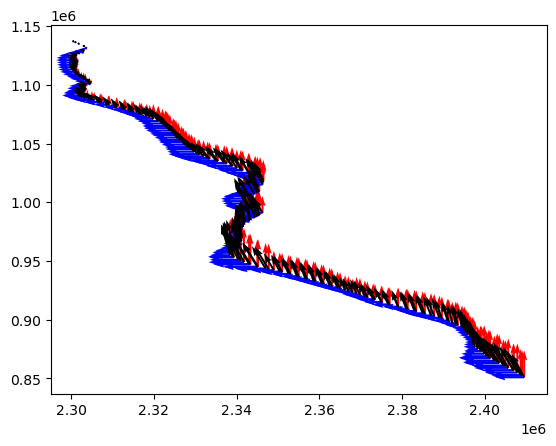

In [718]:
# now we have the azimuth of the contour in radians az_rad.
test= np.pi/2 - az_rad # 90deg - angle (all in rads) to convert to rads away from 0==east.

# I need to add a zero at the end to account for the last angle being missing
#  also use it as a test value. 
# NOTE: make negative to account for +east going clockwise, and positive angles going anti-clockwise
cont_angle = np.concatenate([-test, np.pi/2+np.ones(1)*np.pi/4])

# xrot = u_rho_cont * np.cos(cont_angle) - v_rho_cont * np.sin(cont_angle)
# yrot = u_rho_cont * np.sin(cont_angle) + v_rho_cont * np.cos(cont_angle)


plt.quiver(cont_x,cont_y,np.zeros(len(u_rho_cont[55,-1,:])),v_rho_cont[55,-1,:],color='r')
plt.quiver(cont_x,cont_y,u_rho_cont[55,-1,:],np.zeros(len(v_rho_cont[55,-1,:])),color='b')
plt.quiver(cont_x,cont_y,u_rho_cont[55,-1,:],v_rho_cont[55,-1,:])
plt.show()

# plt.quiver(cont_x,cont_y,np.zeros(len(xrot[55,-1,:])),yrot[55,-1,:],color='r')
# plt.quiver(cont_x,cont_y,xrot[55,-1,:],np.zeros(len(xrot[55,-1,:])),color='b')
# plt.quiver(cont_x,cont_y,xrot[55,-1,:],yrot[55,-1,:])
# plt.show()



# ds_CTRL.u_rho_doy.isel(s_rho=-1,dayofyear=55).plot(x='lon_rho',y='lat_rho')
# plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),xrot,0,scale=.5,color='r')
# plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),0,yrot,scale=.5,color='b')

# plt.quiver(ds_CTRL.lon_rho.isel(xi_rho=413,eta_rho=450),ds_CTRL.lat_rho.isel(xi_rho=413,eta_rho=450),xrot,yrot,scale=.5)
# plt.axis((66,71,-68,-66))


In [719]:
cont_angle[-10:]

array([-0.14067856, -0.19187183, -0.17029639, -0.21280685, -0.12562925,
       -0.10147324, -0.03666215, -0.07894062, -0.0546722 ,  2.35619449])

In [722]:
cont_angle_ux[-10:]

array([-0.140215  , -0.1906967 , -0.16947446, -0.21120426, -0.12529905,
       -0.10129919, -0.03665394, -0.07885865, -0.05464497,  0.70710678])

-0.03455611318349838
0.06365813314914703
2.356194490192345
0.7071067811865476
-0.7071067811865475
[-0.04910712  0.04910712]
[0.01455101 0.01455101]
0.06944795959093958
0.02057823566393646


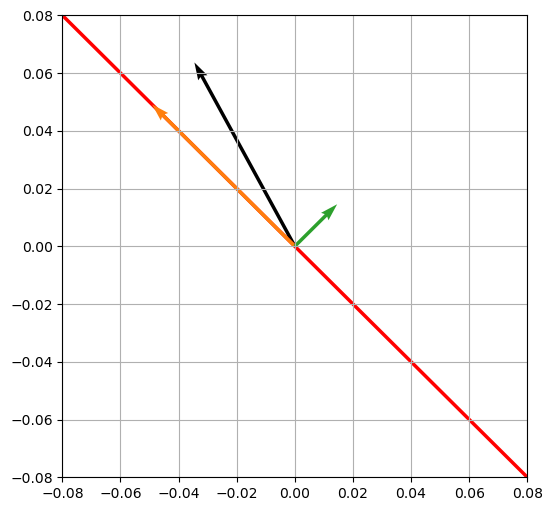

In [720]:
# constract unit vector
cont_angle_ux = np.sin(cont_angle)
cont_angle_uy = np.cos(cont_angle)
magnitude = np.sqrt(cont_angle_ux**2 + cont_angle_uy**2) # should already all be ones

where = -1
print(u_rho_cont[55,-1,where])
print(v_rho_cont[55,-1,where])
print(cont_angle[where])
# print(xrot[55,-1,where])
# print(yrot[55,-1,where])
print(cont_angle_ux[where])
print(cont_angle_uy[where])


a=np.array((u_rho_cont[55,-1,where],v_rho_cont[55,-1,where]))
b=np.array((cont_angle_ux[where]/magnitude[where],cont_angle_uy[where]/magnitude[where]))

a_dot_b_parallel = ((np.dot(a, b) / np.dot(b, b)) * b)
a_dot_b_perp = a-a_dot_b_parallel

print(a_dot_b_parallel)
print(a_dot_b_perp)

print(np.linalg.norm(a_dot_b_parallel))
print(np.linalg.norm(a_dot_b_perp))

plt.figure(figsize=(6,6))
plt.quiver(u_rho_cont[55,-1,where],v_rho_cont[55,-1,where],angles='xy', scale_units='xy', scale=1)
plt.quiver(.1,.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
plt.quiver(-.1,-.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
plt.quiver(a_dot_b_parallel[0],a_dot_b_parallel[1],color='C1',angles='xy', scale_units='xy', scale=1)
plt.quiver(a_dot_b_perp[0],a_dot_b_perp[1],color='C2',angles='xy', scale_units='xy', scale=1)
plt.axis((-.08,.08,-.08,.08))
plt.grid()
# plt.axis('square')

-0.03455611318349838
0.06365813314914703
2.356194490192345
0.7071067811865476
-0.7071067811865475
[-0.04910712  0.04910712]
[0.01455101 0.01455101]
0.06944795959093958
0.02057823566393646


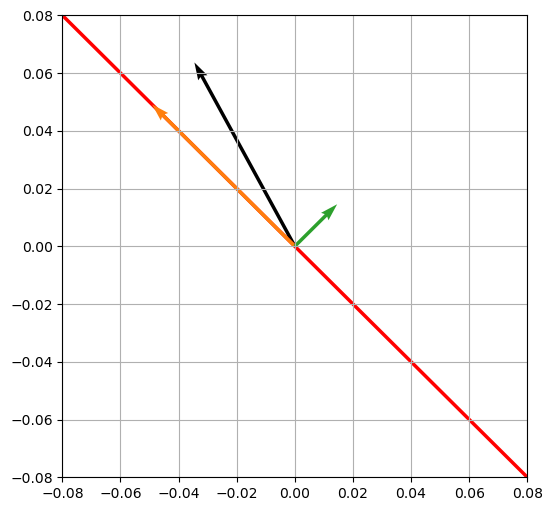

In [709]:
# constract unit vector
cont_angle_ux = np.sin(cont_angle)
cont_angle_uy = np.cos(cont_angle)
magnitude = np.sqrt(cont_angle_ux**2 + cont_angle_uy**2) # should already all be ones

where = -1
print(u_rho_cont[55,-1,where])
print(v_rho_cont[55,-1,where])
print(cont_angle[where])
# print(xrot[55,-1,where])
# print(yrot[55,-1,where])
print(cont_angle_ux[where])
print(cont_angle_uy[where])


a=np.array((u_rho_cont[55,-1,where],v_rho_cont[55,-1,where]))
b=np.array((cont_angle_ux[where]/magnitude[where],cont_angle_uy[where]/magnitude[where]))

a_dot_b_parallel = ((np.dot(a, b) / np.dot(b, b)) * b)
a_dot_b_perp = a-a_dot_b_parallel

print(a_dot_b_parallel)
print(a_dot_b_perp)

print(np.linalg.norm(a_dot_b_parallel))
print(np.linalg.norm(a_dot_b_perp))

plt.figure(figsize=(6,6))
plt.quiver(u_rho_cont[55,-1,where],v_rho_cont[55,-1,where],angles='xy', scale_units='xy', scale=1)
plt.quiver(.1,.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
plt.quiver(-.1,-.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
plt.quiver(a_dot_b_parallel[0],a_dot_b_parallel[1],color='C1',angles='xy', scale_units='xy', scale=1)
plt.quiver(a_dot_b_perp[0],a_dot_b_perp[1],color='C2',angles='xy', scale_units='xy', scale=1)
plt.axis((-.08,.08,-.08,.08))
plt.grid()
# plt.axis('square')

In [612]:
angle_diff

10.456611479657047

In [607]:
u1 = a / np.linalg.norm(a)
u2 = b / np.linalg.norm(b)

minor = np.linalg.det(np.stack((u1, u2)))
    
np.rad2deg(np.sign(minor) * np.arccos(np.clip(np.dot(u1, u2), -1.0, 1.0)))

-163.49483282260655

In [624]:
angle_diff

344.0708592452335

In [626]:
# constract unit vector
cont_angle_ux = np.sin(cont_angle)
cont_angle_uy = np.cos(cont_angle)
magnitude = np.sqrt(cont_angle_ux**2 + cont_angle_uy**2) # should already all be ones
cont_angle_ux = cont_angle_ux/magnitude
cont_angle_uy = cont_angle_uy/magnitude



vel_para = np.empty_like(u_rho_cont)*np.NaN
vel_perp = np.empty_like(u_rho_cont)*np.NaN

for tt in range(len(ds_CTRL.dayofyear)):
    print(tt)
    for ss in range(len(ds_CTRL.s_rho)):
        for ii in range(len(cont_angle_ux)):
            a=np.array((u_rho_cont[tt,ss,ii],v_rho_cont[tt,ss,ii]))
            b=np.array((cont_angle_ux[ii],cont_angle_uy[ii]))
            
            a_dot_b_parallel = ((np.dot(a, b) / np.dot(b, b)) * b)
            a_dot_b_perp = a-a_dot_b_parallel
            
            vel_para[tt,ss,ii] = np.linalg.norm(a_dot_b_parallel)
            vel_perp[tt,ss,ii] = np.linalg.norm(a_dot_b_perp)
            
            u1 = a / np.linalg.norm(a)
            u2 = b / np.linalg.norm(b)

            minor = np.linalg.det(np.stack((u1, u2)))

            angle_diff = np.rad2deg(np.sign(minor) * np.arccos(np.clip(np.dot(u1, u2), -1.0, 1.0)))
            
            angle_diff = angle_diff % 360
            
            if (angle_diff>=0) & (angle_diff<90):
                # do nothing
                1+1
            elif (angle_diff>=90) & (angle_diff<180):
                vel_para[tt,ss,ii] = -1*vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = vel_perp[tt,ss,ii] 
            elif (angle_diff>=180) & (angle_diff<270):
                vel_para[tt,ss,ii] = -1*vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = -1*vel_perp[tt,ss,ii] 
            elif (angle_diff>=270) & (angle_diff<360):
                vel_para[tt,ss,ii] = vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = -1*vel_perp[tt,ss,ii] 
            else:
                print(angle_diff)



# cont_para_length = 

# plt.figure(figsize=(6,6))
# plt.quiver(u_rho_cont[55,-1,where],v_rho_cont[55,-1,where],angles='xy', scale_units='xy', scale=1)
# plt.quiver(.1,.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
# plt.quiver(-.1,-.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
# plt.quiver(xrot[55,-1,where],yrot[55,-1,where],angles='xy', scale_units='xy', scale=1,color='b')
# plt.quiver(a_dot_b_parallel[0],a_dot_b_parallel[1],color='C1',angles='xy', scale_units='xy', scale=1)
# plt.quiver(a_dot_b_perp[0],a_dot_b_perp[1],color='C2',angles='xy', scale_units='xy', scale=1)
# plt.axis((-.08,.08,-.08,.08))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


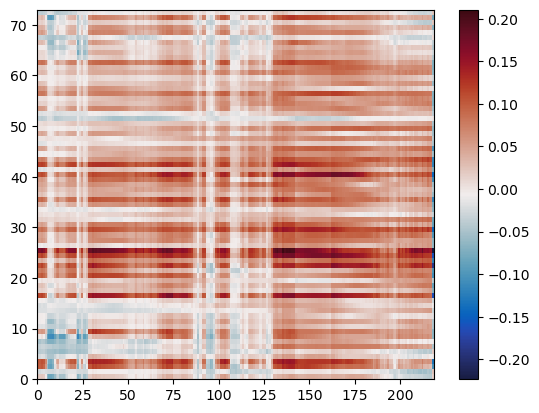

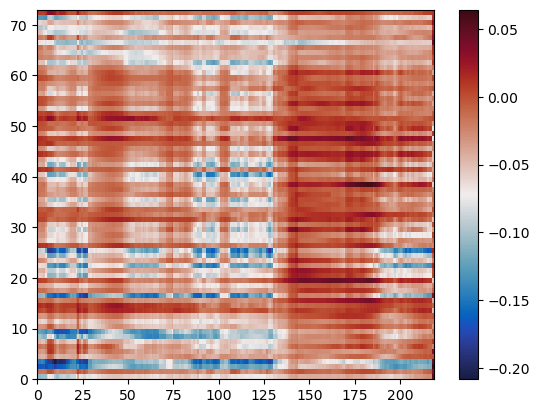

In [629]:
plt.pcolormesh(vel_para[:,-1,:],cmap='cmo.balance')
plt.colorbar()
plt.show()
plt.pcolormesh(vel_perp[:,-1,:],cmap='cmo.balance')
plt.colorbar()
plt.show()


-0.14021500025975142 0.9901210803240975
[-0.01021846  0.07215717]
[-0.03085104 -0.00436894]
0.07287711547402627
0.031158851021312436
-0.19069670488738572 0.9816490038425615
[-0.0129738   0.06678521]
[-0.02518087 -0.00489168]
0.06803369191386527
0.02565160157259311
-0.16947445594195956 0.98553458020669
[-0.0114335   0.06648855]
[-0.02672117 -0.00459502]
0.06746445604595518
0.02711337435829744
-0.21120426779067608 0.9774419457272152
[-0.01610055  0.07451249]
[-0.02475123 -0.00534821]
0.0762321387008677
0.025322452214950834
-0.1252990458634595 0.9921190196270337
[-0.00841238  0.06660928]
[-0.0291118  -0.00367666]
0.06713839320776936
0.029343055434220677
-0.1012991944719537 0.994856006263888
[-0.00672729  0.06606845]
[-0.03079689 -0.00313583]
0.06641006420414347
0.030956132141117698
-0.03665393433544077 0.9993280187694795
[-0.00257209  0.07012502]
[-0.0362952  -0.00133126]
0.0701721709799596
0.03631960994891073
-0.07885865433638212 0.9968858072197914
[-0.00499485  0.06314203]
[-0.03051993 

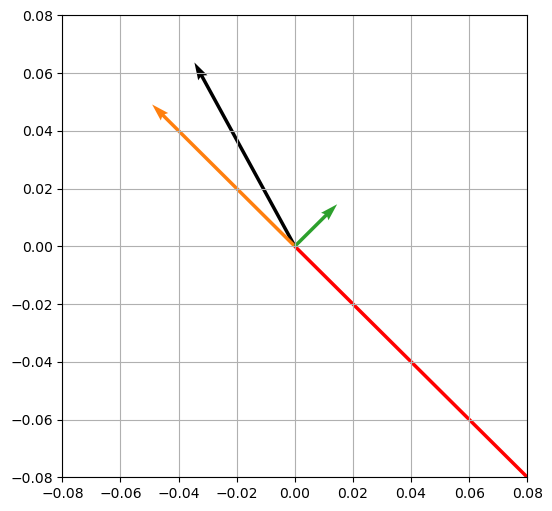

In [732]:
import numpy as np
import matplotlib.pyplot as plt
# code snippet for Glen

#1. the contour values are extracted from a contour plot of bathymetry
cont_x = np.array([2403470.57217553, 2404525.48304445, 2405000.00120472,
       2405677.5317655 , 2406919.56988494, 2407000.00120608,
       2407874.32056099, 2408668.10819209, 2409000.00120766,
       2409522.92026007])
cont_y = np.array([863000.00086656, 861000.00086587, 860200.62368897, 859000.0008652 ,
       857000.00086454, 856840.74961253, 855000.00086383, 853000.0008631 ,
       852255.36843198, 851000.00086238])

#2. bearing is calculated (in rads) from N clockwise.
az_rad = np.array([1.43011777, 1.3789245 , 1.40049994, 1.35798947,
       1.44516708, 1.46932308, 1.53413418, 1.49185571, 1.51612413])

#3. flip to being counterclockwise from East direction.
test= -(np.pi/2 - az_rad) # 90deg - angle (all in rads) to convert to rads away from 0==east., and make negative to account for +east going clockwise
cont_angle = np.concatenate([test, (np.pi/2+np.ones(1)*np.pi/4)]) # add a dummy value to the end, as the original az_rad is one too short (due to being calculated as difference)

#4. each point along the contour has a velocity, made up of eastwards(u) and northwards(v) velocities
u_rho_cont = np.array([-0.0410695 , -0.03815467, -0.03815467, -0.04085178, -0.03752418,
       -0.03752418, -0.03886729, -0.03551478, -0.03551478, -0.03455611])
v_rho_cont = np.array([0.06778823, 0.06189353, 0.06189353, 0.06916428, 0.06293262,
       0.06293262, 0.06879376, 0.06072775, 0.06072775, 0.06365813])

#5. construct unit vector aligned with contour angle, degrees measured from East counterclockwise.
cont_angle_ux = np.sin(cont_angle)
cont_angle_uy = np.cos(cont_angle)
magnitude = np.sqrt(cont_angle_ux**2 + cont_angle_uy**2) # should already all be ones

vel_para = np.empty(len(cont_angle))*np.NaN
vel_perp = np.empty(len(cont_angle))*np.NaN

for nn in range(len(cont_angle)): # I'm sorry, it's a for loop, yes, I know it's shit

    #6. take the dot product of the velocity vectors and the unit vectors.
    print(cont_angle_ux[nn],cont_angle_uy[nn])
    a=np.array((u_rho_cont[nn],v_rho_cont[nn]))
    b=np.array((cont_angle_ux[nn]/magnitude[nn],cont_angle_uy[nn]/magnitude[nn]))

    a_dot_b_parallel = ((np.dot(a, b) / np.dot(b, b)) * b)

    #7. and the rejection (perpendicular) is original velocity vector minus the parallel projection. 
    a_dot_b_perp = a-a_dot_b_parallel

    print(a_dot_b_parallel)
    print(a_dot_b_perp)

    print(np.linalg.norm(a_dot_b_parallel))
    print(np.linalg.norm(a_dot_b_perp))

    #8. and the lengths of these vectors is the component in the perp and para directions
    vel_para[nn] = np.linalg.norm(a_dot_b_parallel)
    vel_perp[nn] = np.linalg.norm(a_dot_b_perp)

    #9. now calculate angle between contour vector and velocity vector

    minor = np.linalg.det(np.stack((a, b)))
    angle_diff = np.rad2deg(np.sign(minor) * np.arccos(np.clip(np.dot(u1, u2), -1.0, 1.0)))
    angle_diff = angle_diff % 360 # wrap any degrees >360 or <360 around.

    #10. and add signs depending on which quadrant.
    if (angle_diff>=0) & (angle_diff<90):
        # do nothing
        1+1
    elif (angle_diff>=90) & (angle_diff<180):
        vel_para[nn] = -1*vel_para[nn]
        vel_perp[nn] = vel_perp[nn]
    elif (angle_diff>=180) & (angle_diff<270):
        vel_para[nn] = -1*vel_para[nn]
        vel_perp[nn] = -1*vel_perp[nn]
    elif (angle_diff>=270) & (angle_diff<360):
        vel_para[nn] = vel_para[nn]
        vel_perp[nn] = -1*vel_perp[nn]
    else:
        print(angle_diff)

where=-1
plt.figure(figsize=(6,6))
plt.quiver(u_rho_cont[where],v_rho_cont[where],angles='xy', scale_units='xy', scale=1)
plt.quiver(.1,.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1) # this plots the contour angle as avector
# plt.quiver(-.1,-.1*np.tan(-cont_angle[where]+np.deg2rad(90)),color='r',angles='xy', scale_units='xy', scale=1)
plt.quiver(a_dot_b_parallel[0],a_dot_b_parallel[1],color='C1',angles='xy', scale_units='xy', scale=1) # I'm only saving last a_dot_b_parallel/perp vector, but this plots the parallel projected components
plt.quiver(a_dot_b_perp[0],a_dot_b_perp[1],color='C2',angles='xy', scale_units='xy', scale=1)
plt.axis((-.08,.08,-.08,.08))
plt.grid()



In [ ]:
STOP

In [ ]:
# cape darnley-center bottom salinity in sensitivity studies

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='CTRL')
ds_AIS0.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C1', linewidth=1.5,label='no-AIS')
ds_AIS2.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C2', linewidth=1.5,label='AISx2')
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b  CD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c no-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS2.ocean_time,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
co=plt.contour(ds_AIS2.ocean_time,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd  AISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

In [ ]:
# # test sum salt in one of the boxes

# gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[9,6])
# ax = None

# ax=fig.add_subplot(gs[0,0])
# ds_CTRL.my.isel(eta_rho=408,xi_rho=400).plot(color='C0', linewidth=1.5)
# # (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
# ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_title('')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# ax=fig.add_subplot(gs[1,0])
# plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_CTRL.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_CTRL.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.text(0.01, 0.99, 'b  CD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# ax=fig.add_subplot(gs[2,0])
# im=plt.pcolormesh(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# plt.contour(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.text(0.01, 0.99, 'c  CD salinity (no-FIT)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


# ax=fig.add_subplot(gs[3,0])
# im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# co=plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# # ax.clabel(co)
# ax.text(0.01, 0.99, 'd  CD salinity (no-AIS)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.25, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
# cax.set_title(r'Salinity')

In [ ]:
# # test sum salt in one of the boxes

# gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[9,6])
# ax = None

# ax=fig.add_subplot(gs[0,0])
# ds_CTRL.my.isel(eta_rho=408,xi_rho=400).plot(color='C0', linewidth=1.5)
# # (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
# ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_title('')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# ax=fig.add_subplot(gs[1,0])
# plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_CTRL.salt.isel(xi_rho=390,eta_rho=440).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_CTRL.salt.isel(xi_rho=390,eta_rho=440).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.text(0.01, 0.99, 'b  CD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# ax=fig.add_subplot(gs[2,0])
# im=plt.pcolormesh(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.isel(xi_rho=390,eta_rho=440).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# plt.contour(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.isel(xi_rho=390,eta_rho=440).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.text(0.01, 0.99, 'c  CD salinity (no-FIT)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


# ax=fig.add_subplot(gs[3,0])
# im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.isel(xi_rho=390,eta_rho=440).T,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# co=plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.isel(xi_rho=390,eta_rho=440).T,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# # ax.clabel(co)
# ax.text(0.01, 0.99, 'd  CD salinity (no-AIS)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.25, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
# cax.set_title(r'Salinity')




In [ ]:
# now cape darnley salinity, but add a difference plot

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='CTRL')
ds_AIS0.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C1', linewidth=1.5,label='no-AIS')
ds_AIS2.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C2', linewidth=1.5,label='AISx2')
ds_CTRL.my.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C2', linewidth=1.5)
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])

CTRL =  ds_CTRL.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b  CD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-1,vmax=1)
# plt.colorbar()
plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-1,1,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c  no-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS2.ocean_time,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
              cmap='cmo.balance',vmin=-1,vmax=1)
# plt.colorbar()
co=plt.contour(ds_AIS2.ocean_time,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
            levels=np.arange(-1,1,0.1),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd  AISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5)
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5,label='no-AIS')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='-.', linewidth=1.5,label='AISx2')
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5)
ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AISx2')
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('melt (m/yr)')

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[1,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
co=plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
            levels=np.arange(-.5,.5,0.1),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=5,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4, .4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,8])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5)
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5,label='no-AIS')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='-.', linewidth=1.5,label='AISx2')
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5)
ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AISx2')
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('melt (m/yr)')

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[1,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS05.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nAISx0.5', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=fig.add_subplot(gs[4,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
co=plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
            levels=np.arange(-.5,.5,0.1),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
# # test sum salt in one of the boxes

# gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[9,6])
# ax = None

# ax=fig.add_subplot(gs[0,0])
# ds_CTRL.my.isel(eta_rho=408,xi_rho=400).plot(color='C0', linewidth=1.5)
# # (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
# ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_title('')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# CTRL =  ds_CTRL.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T

# ax=fig.add_subplot(gs[1,0])
# plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#               CTRL,shading='gouraud',
#               cmap='cmo.haline',vmin=34,vmax=35)
# # plt.colorbar()
# plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                CTRL,
#             levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.text(0.01, 0.99, 'b  CD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.set_xlabel('')
# ax.set_xticklabels([])

# ax=fig.add_subplot(gs[2,0])
# im=plt.pcolormesh(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
#               cmap='cmo.balance',vmin=-.5,vmax=.5)
# # plt.colorbar()
# plt.contour(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_FIT0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
#             levels=np.arange(-.5,.5,.1),colors='k')
# ax.text(0.01, 0.99, 'c  CD salinity (no-FIT)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


# ax=fig.add_subplot(gs[3,0])
# im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
#               cmap='cmo.balance',vmin=-.5,vmax=.5)
# # plt.colorbar()
# co=plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
#             levels=np.arange(-.5,.5,0.1),colors='k')
# # ax.clabel(co)
# ax.text(0.01, 0.99, 'd  CD salinity (no-AIS)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.25, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
# cax.set_title(r'Salinity')


# ### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
# ## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

### now make a more finalised plot

In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=5,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,9])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='--',label='FIT (no-AIS)')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='-.',label='FIT (AISx2)')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,label='AIS (CTRL)')
# ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (AISx2)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs[1,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[2,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[4,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

### now check same, but take average across whole CD polynya

In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=5,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,9])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='--',label='FIT (no-AIS)')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='-.',label='FIT (AISx2)')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,label='AIS (CTRL)')
# ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (AISx2)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs[1,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[2,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[4,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=6,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,9])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C1', linewidth=1.5,linestyle='-',label='FIT (no-AIS)')
ds_AIS05.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C2', linewidth=1.5,linestyle='-',label='FIT (AISx0.5)')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C3', linewidth=1.5,linestyle='-',label='FIT (AISx2)')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,linestyle='--',label='AIS (CTRL)')
# ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (AISx2)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs[1,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='AISx0.5')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C3',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[2,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[4,0])
im=plt.pcolormesh(ds_AIS05.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS05.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx0.5', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[5,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
### add a nice 45 deg plot

# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=5,ncols=4,wspace=0.4, hspace=0.15,height_ratios=[.3,.4,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,9])
ax = None

ax=fig.add_subplot(gs[0,0:3])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='--',label='FIT (no-AIS)')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='-.',label='FIT (AISx2)')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,label='AIS (CTRL)')
# ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (AISx2)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs[1,0:3])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T



ax=fig.add_subplot(gs[0:2,3])
pltx_1=ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_1=ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m1,b1 = np.polyfit(pltx_1, plty_1,deg=1)
pltx_i_1 = np.arange(pltx_1.min(),pltx_1.max(),0.001)
pltx_2=ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_2=ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m2,b2 = np.polyfit(pltx_2, plty_2,deg=1)
pltx_i_2 = np.arange(pltx_2.min(),pltx_2.max(),0.001)

sc=ax.scatter(pltx_1,plty_1,s=10,c='0.8',label='CTRL')
ax.plot(pltx_i_1,m1*pltx_i_1+b1,color='0.8',linestyle='--')
sc=ax.scatter(pltx_2,plty_2,s=10,c='C1',label='AISx2')
ax.plot(pltx_i_2,m2*pltx_i_2+b2,color='C1',linestyle='--')
ax.legend(frameon=False)



ax=fig.add_subplot(gs[2,:])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')



ax=fig.add_subplot(gs[3,:])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[4,:])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:
### add a nice 45 deg plot

# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,9])
ax = None


gs0 = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.035, hspace=0.14)

gs00 = gs0[0].subgridspec(2, 2,wspace=0.2, hspace=0.05,width_ratios=[0.6,0.4])


ax=fig.add_subplot(gs00[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='--',label='FIT (no-AIS)')
ds_AIS2.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,linestyle='-.',label='FIT (AISx2)')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,label='AIS (CTRL)')
# ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (AISx2)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs00[1,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T



ax=fig.add_subplot(gs00[:,1])
pltx_1=ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_1=ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m1,b1 = np.polyfit(pltx_1, plty_1,deg=1)
pltx_i_1 = np.arange(pltx_1.min(),pltx_1.max(),0.001)
pltx_2=ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_2=ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m2,b2 = np.polyfit(pltx_2, plty_2,deg=1)
pltx_i_2 = np.arange(pltx_2.min(),pltx_2.max(),0.001)

sc=ax.scatter(pltx_1,plty_1,s=10,c='0.8',label='CTRL')
ax.plot(pltx_i_1,m1*pltx_i_1+b1,color='0.8',linestyle='--')
sc=ax.scatter(pltx_2,plty_2,s=10,c='C1',label='AISx2')
ax.plot(pltx_i_2,m2*pltx_i_2+b2,color='C1',linestyle='--')
ax.legend(frameon=False)

gs01 = gs0[1].subgridspec(3, 1,wspace=0.035, hspace=0.05)


ax=fig.add_subplot(gs01[0,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')



ax=fig.add_subplot(gs01[1,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=fig.add_subplot(gs01[2,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:

fig,ax=plt.subplots()

pltx_1=ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_1=ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m1,b1 = np.polyfit(pltx_1, plty_1,deg=1)
pltx_i_1 = np.arange(pltx_1.min(),pltx_1.max(),0.001)

pltx_2=ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_2=ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m2,b2 = np.polyfit(pltx_2, plty_2,deg=1)
pltx_i_2 = np.arange(pltx_2.min(),pltx_2.max(),0.001)

pltx_3=ds_AIS05.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
plty_3=ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m3,b3 = np.polyfit(pltx_3, plty_3,deg=1)
pltx_i_3 = np.arange(pltx_3.min(),pltx_3.max(),0.001)

sc=ax.scatter(pltx_1,plty_1,s=10,c='0.8',label='CTRL')
ax.plot(pltx_i_1,m1*pltx_i_1+b1,color='0.8',linestyle='--')
sc=ax.scatter(pltx_2,plty_2,s=10,c='C1',label='AISx2')
ax.plot(pltx_i_2,m2*pltx_i_2+b2,color='C1',linestyle='--')
sc=ax.scatter(pltx_3,plty_3,s=10,c='C2',label='AISx0.5')
ax.plot(pltx_i_3,m3*pltx_i_3+b3,color='C2',linestyle='--')
ax.legend(frameon=False)

In [ ]:
#normalise by mean melt rate.


fig,ax=plt.subplots()


pltx_1=ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_1=ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m1,b1 = np.polyfit(pltx_1, plty_1,deg=1)
pltx_i_1 = np.arange(pltx_1.min(),pltx_1.max(),0.001)

pltx_2=ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_2=ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m2,b2 = np.polyfit(pltx_2, plty_2,deg=1)
pltx_i_2 = np.arange(pltx_2.min(),pltx_2.max(),0.001)

pltx_3=ds_AIS05.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_AIS05.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_3=ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
m3,b3 = np.polyfit(pltx_3, plty_3,deg=1)
pltx_i_3 = np.arange(pltx_3.min(),pltx_3.max(),0.001)

sc=ax.scatter(pltx_3,plty_3,s=10,c='C2',label='AISx0.5')
ax.plot(pltx_i_3,m3*pltx_i_3+b3,color='C2',linestyle='--')
sc=ax.scatter(pltx_1,plty_1,s=10,c='0.8',label='CTRL')
ax.plot(pltx_i_1,m1*pltx_i_1+b1,color='0.8',linestyle='--')
sc=ax.scatter(pltx_2,plty_2,s=10,c='C1',label='AISx2')
ax.plot(pltx_i_2,m2*pltx_i_2+b2,color='C1',linestyle='--')

ax.legend(frameon=False)
ax.set_xlabel('Normalised melt rate')
ax.set_ylabel('CD bottom salinity')

In [ ]:
#normalise by mean melt rate and normalise CD too.


fig,ax=plt.subplots()


pltx_1=ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_1=ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
m1,b1 = np.polyfit(pltx_1, plty_1,deg=1)
pltx_i_1 = np.arange(pltx_1.min(),pltx_1.max(),0.001)

pltx_2=ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_AIS2.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_2=ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))/ ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
m2,b2 = np.polyfit(pltx_2, plty_2,deg=1)
pltx_i_2 = np.arange(pltx_2.min(),pltx_2.max(),0.001)

pltx_3=ds_AIS05.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')) / ds_AIS05.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
plty_3=ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))/ ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).mean(dim='dayofyear')
m3,b3 = np.polyfit(pltx_3, plty_3,deg=1)
pltx_i_3 = np.arange(pltx_3.min(),pltx_3.max(),0.001)

sc=ax.scatter(pltx_3,plty_3,s=10,c='C2',label='AISx0.5')
ax.plot(pltx_i_3,m3*pltx_i_3+b3,color='C2',linestyle='--')
sc=ax.scatter(pltx_1,plty_1,s=10,c='0.8',label='CTRL')
ax.plot(pltx_i_1,m1*pltx_i_1+b1,color='0.8',linestyle='--')
sc=ax.scatter(pltx_2,plty_2,s=10,c='C1',label='AISx2')
ax.plot(pltx_i_2,m2*pltx_i_2+b2,color='C1',linestyle='--')

ax.legend(frameon=False)
ax.set_xlabel('Normalised melt rate')
ax.set_ylabel('Normalised CD bottom salinity')

### now check equivalent in the burton basin.

In [ ]:
# cape darnley-center bottom salinity in sensitivity studies

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5)
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.ocean_time,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
ax.text(0.01, 0.99, 'b  BB salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_FIT0.ocean_time,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
ax.text(0.01, 0.99, 'c  no-FIT', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
co=plt.contour(ds_AIS0.ocean_time,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
# ax.clabel(co)
ax.text(0.01, 0.99, 'd \n no-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

In [ ]:
# BB bottom salinity in sensitivity studies

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5)
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
# (ds.my*ds.mask_ziceNaN.where(mask_cdit==1)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'a  Fast ice tongue melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_CTRL.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b  BB salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c  no-FIT', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
co=plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd  \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

In [ ]:
# now BB salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,6])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5)
ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)

ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5)
ds_FIT0.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5)

ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('melt (m/yr)')

CTRL =  ds_CTRL.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[1,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b  \nBB salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c  \nno-FIT', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
co=plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS0.salt_doy.where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
            levels=np.arange(-.5,.5,0.05),colors='k',linewidths=1)
# ax.clabel(co)
ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_FIT0.salt_doy.isel(s_rho=0).where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-FIT')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_burton_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.text(0.01, 0.99, '  Burton Basin bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=True)


In [ ]:
ds_CTRL.ocean_time.isel(ocean_time=19).values

In [ ]:
ub_rho_ctrl_1   = ds_CTRL.u_rho.isel(s_rho=-2).isel(ocean_time=slice(0,1)).mean(dim='ocean_time').values   
vb_rho_ctrl_1   = ds_CTRL.v_rho.isel(s_rho=-2).isel(ocean_time=slice(0,1)).mean(dim='ocean_time').values 
ub_rho_ctrl_4   = ds_CTRL.u_rho.isel(s_rho=-2).isel(ocean_time=slice(18,19)).mean(dim='ocean_time').values   
vb_rho_ctrl_4   = ds_CTRL.v_rho.isel(s_rho=-2).isel(ocean_time=slice(18,19)).mean(dim='ocean_time').values 
ub_rho_ais0_1   = ds_AIS0.u_rho.isel(s_rho=-2).isel(ocean_time=slice(0,1)).mean(dim='ocean_time').values   
vb_rho_ais0_1   = ds_AIS0.v_rho.isel(s_rho=-2).isel(ocean_time=slice(0,1)).mean(dim='ocean_time').values   
ub_rho_ais0_4   = ds_AIS0.u_rho.isel(s_rho=-2).isel(ocean_time=slice(18,19)).mean(dim='ocean_time').values   
vb_rho_ais0_4   = ds_AIS0.v_rho.isel(s_rho=-2).isel(ocean_time=slice(18,19)).mean(dim='ocean_time').values   

# uvel1=ub_rho_ctrl
# vvel1=vb_rho_ctrl
# uvel2=ub_rho_mkpa
# vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
sss=-2
diff_plot_1 = -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=slice(0,1)).mean(dim='ocean_time'))+ (ds_AIS0.mask_rho*(ds_AIS0.mask_rhoNaN)*ds_AIS0.salt.isel(s_rho=sss).isel(ocean_time=slice(0,1)).mean(dim='ocean_time')) 

diff_plot_4 = -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=slice(18,19)).mean(dim='ocean_time'))+ (ds_AIS0.mask_rho*(ds_AIS0.mask_rhoNaN)*ds_AIS0.salt.isel(s_rho=sss).isel(ocean_time=slice(18,19)).mean(dim='ocean_time')) 

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=slice(6,7)).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], ub_rho_ctrl_1[0::5,0::5], vb_rho_ctrl_1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'a  Winter-time Mackenzie polynya', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')




ax=fig.add_subplot(gs[0,1])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=slice(18,19)).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], ub_rho_ctrl_4[0::5,0::5], vb_rho_ctrl_4[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'a  Winter-time Mackenzie polynya', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')




ax=fig.add_subplot(gs[1,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot_1.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], ub_rho_ais0_1[0::5,0::5], vb_rho_ais0_1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'a  Winter-time Mackenzie polynya', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,1])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot_4.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], ub_rho_ais0_4[0::5,0::5], vb_rho_ais0_4[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'b  ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
sss=0
ttt=18
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=ttt)) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt.isel(s_rho=sss).isel(ocean_time=ttt))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[1,0])
sss=15
ttt=18
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=ttt)) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt.isel(s_rho=sss).isel(ocean_time=ttt))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
sss=-1
ttt=8
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=sss).isel(ocean_time=ttt)) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt.isel(s_rho=sss).isel(ocean_time=ttt))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))



In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_FIT0.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-FIT')
(ds_AIS0.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C2',linewidth=1.5,label='No-AIS')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=True)


In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_FIT0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-FIT')
ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.text(0.01, 0.99, '  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=True)


In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
sss=0
ttt=100
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[1,0])
sss=15
ttt=100
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
sss=-1
ttt=100
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))



In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
sss=-3
ttt=50
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[1,0])
sss=15
ttt=90
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
sss=0
ttt=100
im =( -(ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance') #,cmap='cmo.haline',vmin=34.4,vmax=34.7)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))



In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None


ax=fig.add_subplot(gs[0,0])
sss=-3
ttt=50
im =( (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=33.0,vmax=34.2)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[1,0])
sss=-3
ttt=50
im =( (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_AIS0.salt_doy.isel(s_rho=sss).sel(dayofyear=ttt,method='nearest'))).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=33.0,vmax=34.2)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))




In [ ]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.3,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,9])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0', linewidth=1.5,label='FIT')
# ds_AIS0.my_doy.where(mask_fasticetongue==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(color='C0',linestyle='--', linewidth=1.5)
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2', linewidth=1.5,label='AIS')
ds_FIT0.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax2,color='C2',linestyle='--', linewidth=1.5,label='AIS (no-FIT)')
ax2.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('FIT melt (m/yr)')
ax.set_xlim((0,365))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False)

ax=fig.add_subplot(gs[1,0])
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
ax.plot(ds_CTRL.dayofyear,ds_FIT0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-FIT')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'b  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,365))

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T

ax=fig.add_subplot(gs[2,0])
im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k')
ax.text(0.01, 0.99, 'c \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_FIT0.dayofyear,ds_FIT0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_FIT0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nno-FIT', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


# ax=fig.add_subplot(gs[3,0])
# im=plt.pcolormesh(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,shading='gouraud',
#               cmap='cmo.balance',vmin=-.5,vmax=.5)
# # plt.colorbar()
# co=plt.contour(ds_AIS0.dayofyear,ds_AIS0.z_rho0.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')),
#                ds_AIS0.salt_doy.where(mask_capedarnley_center==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL.values,
#             levels=np.arange(-.5,.5,0.1),colors='k',linewidths=1)
# # ax.clabel(co)
# ax.text(0.01, 0.99, 'd \nno-AIS', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')


### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [ ]:


STOPz_rho0

In [ ]:
# test plot salt in SDW period

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
diff_plot = (ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) - (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Winter salinity difference (No-Mackenzie - CTRL; +ve is increased salinity)')


# annotations


In [ ]:

# us_rho_sum   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# vs_rho_sum   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# us_rho_win   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
# vs_rho_win   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# diff_plot = (ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) - (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,4])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)


# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.1e6,2.4e6))
ax.set_ylim((.72e6,.88e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')



ax=fig.add_subplot(gs[0,1])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::2,0::2], grd.y_rho.values[0::2,0::2], uvel2[0::2,0::2], vvel2[0::2,0::2],scale=2,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.1e6,2.4e6))
ax.set_ylim((.72e6,0.88e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Bottom salinity')


# annotations


In [ ]:
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2,height_ratios=[2,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'a  Winter-time Mackenzie polynya', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=True)



In [ ]:
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

diff_plot2 = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.my.isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.my.isel(ocean_time=winter_period).mean(dim='ocean_time'))



gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.2,height_ratios=[2,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

#####################################

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.curl',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """a  Salinity impact
   of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')




#####################################

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot2.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-1,vmax=1,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """b  Melt rate impact
  of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ melt (m/yr; CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
# ax.legend(frameon=True)



ax=fig.add_subplot(gs[1,1])
(ds_CTRL.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  AIS melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=False,loc='lower left')
ax.set_ylabel('melt rate (m/yr)')


In [ ]:
STOP

In [ ]:
# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.035, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,6])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



In [ ]:

# us_rho_sum   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# vs_rho_sum   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# us_rho_win   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
# vs_rho_win   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_sum   = ds.u_rho.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
vb_rho_sum   = ds.v_rho.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
ub_rho_win   = ds.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_win   = ds.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_sum
vvel1=vb_rho_sum
uvel2=ub_rho_win
vvel2=vb_rho_win


# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.035, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,6])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)





In [ ]:
# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.05,height_ratios=[2.5,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)


########### make two quick time series plots


ax=fig.add_subplot(gs[1,0])
(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',
                                                                                                               linewidth=1.5)

ax=fig.add_subplot(gs[1,1])
ds.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440).plot(color='C1',linewidth=1.5)


In [ ]:
STOP

In [ ]:
# # make 400m transects
# target_depth = -400

# target_time = slice(5,18)
# temp400_FM = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_FM = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_FM = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()




# target_time = slice(55,67)
# temp400_ON = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_ON = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_ON = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_ON = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()


In [ ]:
import seawater as sw
sw.temp(35,-2,1000)

In [ ]:
aa=-5.73e-2
bb=9.39e-2
cc=-7.61e-4


Tb_FM = ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
Sb_FM = ds.salt.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')

Tf = aa*Sb_FM + bb + cc*-ds.zice


Tb_insitu = sw.temp(Sb_FM,Tb_FM,-ds.z_rho0.isel(s_rho=-1).values)

Tstar = (Tb_insitu-Tf)*ds.mask_zice_nan


In [ ]:
uvel=ds.u_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))
plt.show()

Tstar.plot.pcolormesh(x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.5,vmax=.5)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()

st = plt.pcolormesh(ds.x_rho.values, ds.y_rho.values, vel_mag,)
st = plt.quiver(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,scale=15,minshaft = 1, minlength=0)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()


# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# temp400_ON.plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-.5,levels=12)
# st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
# co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
# plt.xlim((2.2e6,2.47e6))
# plt.ylim((.4e6,1.0e6))

In [ ]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,4))

ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.8,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  surface temp (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')

ax=fig.add_subplot(gs[1,0])
Tstar.plot.pcolormesh(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.4,vmax=.4)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
ax.text(0.01, 0.99, 'b  $T^*$ (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



In [ ]:
ds.temp.isel(s_rho=-1,ocean_time=0).plot()
plt.axis((300,500,350,450))
plt.show()
ds.temp.isel(s_rho=-1,eta_rho=395,xi_rho=350).plot()
plt.show()
plt.plot(ds.salt.isel(s_rho=-1,eta_rho=395,xi_rho=350),'.')


In [ ]:



gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,6])
ax = None


ax=fig.add_subplot(gs[0,0])
# im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
im=Tstar.plot.pcolormesh(x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.5,vmax=.5,add_colorbar=False)
# st = plt.quiver(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,scale=15,minshaft = 1, minlength=0)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((1.65e6,2.3e6,.6e6,.84e6))

# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.text(0.01, 0.99, 'T$^*$ ($^\circ$C)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')

ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Thermal driving ($^\circ$C)')




# # convert polarstereo to lat/lon and vice versa.
# from pyproj import Transformer
# from pyproj import CRS
# ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
# ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# arr_start_ps=(2.2125e6,0.45e6)
# arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
# print(arr_start_ps)
# arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
# print(arr_end)
# ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
#     xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
#     color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
# ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# # uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# # vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# # vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# # str_kwargs = {"color":vel_mag.values,
# #               "linewidth":1,
# #               "arrowsize":1,
# #               "density":8,
# #               "cmap":"pink"}
# ax=fig.add_subplot(gs[0,1])
# im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(270,330)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
# ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=2.5)

# # st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# # po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
# co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
# co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
# ax.set_xlim((2.2e6,2.6e6))
# ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.text(0.01, 0.99, 'b  surface temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.grid()
# scale_ticks = 1e3
# ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# ax.set_title('')










In [ ]:
STOP

In [ ]:
uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5

str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":5,
              "cmap":"pink"}


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,8))
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
# ax.set_xlabel('')
ax.text(0.01, 0.99, 'c  surface temp\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

ax=fig.add_subplot(gs[0,0])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,0])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[0,1])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,1])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))





In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  400m\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(1.75e6,.625e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  400m temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="175%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')



ax=fig.add_subplot(gs[1,0])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'c  400m salt\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xticklabels([])
ax.set_ylabel('Northings (km)')
# ax.set_xlabel('')
ax.set_xlabel('Eastings (km)')


ax=fig.add_subplot(gs[1,1])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'd 400m salt\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ax.set_ylabel('Depth (m)')
ax.set_xlabel('Eastings (km)')
ax.set_yticklabels([])

cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'salinity')








In [ ]:
# ds.mke.isel(s_rho=-2).plot(cmap='inferno')

In [ ]:
# ds.eke.isel(s_rho=-2).mean(dim='ocean_time').plot(cmap='cividis')